In [25]:
import os
import json
import requests
from datetime import datetime, timedelta, timezone
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from dotenv import load_dotenv

In [2]:
# helper functions
def get_key():
    "Get the API key from an .env file"
    if ".env" not in os.listdir("../"):
        print("Configuring API Key...")
        key = input("Amberdata API Key: ")
        with open("../.env", "w") as f:
            f.write(f"AMBERDATA_API_KEY={key}\n")
    load_dotenv(verbose=True)
    return {
        "AMBERDATA_API_KEY": os.getenv("AMBERDATA_API_KEY")
    }

def get_response(url, headers=None, queryString=None):
    "Get the REST response from the specified URL"
    if not headers:
        headers = {'x-api-key': api_key["AMBERDATA_API_KEY"]}
    if queryString:
        response = requests.request("GET", url, headers=headers, params=queryString)
    else:
        response = requests.request("GET", url, headers=headers)
    response = json.loads(response.text)
    try:
        if response["title"] == "OK":
            return response["payload"]
    except Exception as e:
        print(e)
        return None

    
api_key = get_key()

In [60]:
res1 = pd.read_csv("../data/results_old.csv", sep='; ', engine='python')
res2 = pd.read_csv("../data/results_pi.csv", sep='; ', engine='python')

df = pd.concat([res1, res2])

df["timestamp"] = pd.to_datetime(df.timestamp, utc=True)

df["btc"] = df.value // 10**8


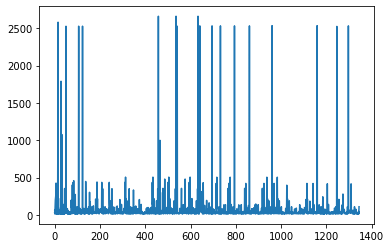

In [5]:
df.btc.plot()

In [19]:
dfs = []

for i in range(5):
    print(f"Iteration: {i}")
    # get the start and end dates in timestamps
    startDate = df.timestamp.min() + timedelta(i-1)
    endDate = startDate + timedelta(1)
    
    # convert to UNIX format
    startDate = str(round(startDate.timestamp()*10**3))
    endDate = str(round(endDate.timestamp()*10**3))

    # the url for our endpoint
    url = "https://web3api.io/api/v2/market/ohlcv/btc_usd/historical"
    
    # our query
    querystring = {
        "timeInterval": "minutes", 
        "timeFormat": "iso",
        'startDate': startDate, 
        'endDate': endDate, 
        "exchange": "bitfinex"
    }
    
    # the API key
    headers = {'x-api-key': api_key["AMBERDATA_API_KEY"]}

    # the response for our query
    payload = get_response(url, headers, querystring)
    
    # we save the OHLCV data
    bfx = payload['data']['bitfinex']

    # get the columns and make a dataframe
    columns = payload['metadata']['columns']
    bfx_df = pd.DataFrame(bfx, columns=columns)
    # append the dataframe to a list
    dfs.append(bfx_df)


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


In [74]:
ohlcv = pd.concat(dfs)

In [79]:
ohlcv.to_csv("../data/ohlcv.csv", index=False)

In [76]:
ohlcv["timestamp"] = pd.to_datetime(ohlcv.timestamp)

In [80]:
ohlcv = ohlcv[ohlcv.timestamp <= df.timestamp.max()]
ohlcv = ohlcv[ohlcv.timestamp >= df.timestamp.min()]

In [86]:
ohlcv.drop(['open', 'high', 'low'], axis=1, inplace=True)

In [87]:
df

,timestamp,address,value,btc
0,2020-08-06 14:25:03.329896+00:00,"'3AVLMuAgA8Bm9mz5JPZx1sw2gcfHxkMqTE', '12QY6M2...",3000002651,30
1,2020-08-06 14:28:47.552292+00:00,"'3DdVsZrbzaVJny56UAR5BgsXdWiZoyo7wZ', '3Dd2mMn...",1683814533,16
2,2020-08-06 14:29:37.736201+00:00,'3GLrQ3tTpxQoHdzb6yd74jrhU22sLwZZKh',11971431236,119
3,2020-08-06 14:31:02.032051+00:00,'1XYZJsM6cnyuDMVnfFufb8dzVM7cS5rqd',19999876016,199
4,2020-08-06 14:31:02.573763+00:00,"'1Kr6QSydW9bFQG1mXiPNNu6WpJGmUa9i1g', '32Bx8GY...",23493932386,234
...,...,...,...,...
1340,2020-08-08 14:34:38.825283+00:00,'bc1qzauquttysl45qncayyrkv306ze9mqk5wh6jxh7',2285267904,22
1341,2020-08-08 14:34:56.438636+00:00,"'3QoPyQHCkxmZaQfxCkggmfVQFX1rzYPaeh', '3Jvg4ra...",1965644082,19
1342,2020-08-08 14:35:01.678496+00:00,"'353sSgMRJzBfkQh3j64yd3EDNr3dp6vqxL', '33HrtTL...",4758400520,47
1343,2020-08-08 14:38:04.883170+00:00,'327r6SqtqXUqPAaDV9Em6gbxiP69ygPZvy',1577791125,15


In [92]:
df.sort_values("value", ascending=False).iloc[:25]

,timestamp,address,value,btc
633,2020-08-08 11:32:12.319119+00:00,'3AjNkWfXhKc69ZhJ2M8W4hcUBxvaPg6RCa',265974848572,2659
458,2020-08-08 11:12:34.296465+00:00,'3AjNkWfXhKc69ZhJ2M8W4hcUBxvaPg6RCa',265974848572,2659
536,2020-08-08 11:26:33.651252+00:00,'3AjNkWfXhKc69ZhJ2M8W4hcUBxvaPg6RCa',265974848572,2659
15,2020-08-07 21:49:04.494414+00:00,"'19iqYbeATe4RxghQZJnYVFU4mjUUu76EA6', '37uCrYm...",257937212958,2579
1159,2020-08-08 13:38:09.017487+00:00,"'19iqYbeATe4RxghQZJnYVFU4mjUUu76EA6', '3KRQybs...",253387299326,2533
960,2020-08-08 12:39:04.034435+00:00,"'19iqYbeATe4RxghQZJnYVFU4mjUUu76EA6', '32PnQzq...",253349274706,2533
860,2020-08-08 12:25:09.777823+00:00,"'19iqYbeATe4RxghQZJnYVFU4mjUUu76EA6', '3GtkaDY...",253092669150,2530
732,2020-08-08 12:07:05.135212+00:00,"'19iqYbeATe4RxghQZJnYVFU4mjUUu76EA6', '3GtkaDY...",253092669150,2530
794,2020-08-08 12:19:07.696129+00:00,"'19iqYbeATe4RxghQZJnYVFU4mjUUu76EA6', '3GtkaDY...",253092669150,2530
695,2020-08-08 11:56:04.704138+00:00,"'19iqYbeATe4RxghQZJnYVFU4mjUUu76EA6', '3GtkaDY...",253092669150,2530
